In [1]:
import spotchaos.syntheticSignals as sp

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import TimedAnimation
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pickle

import os
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr
from scipy.signal import argrelextrema, savgol_filter, find_peaks_cwt, medfilt, butter, sosfilt
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit

from pytisean import tiseano, tiseanio

from sklearn.neighbors import KDTree, BallTree
from scipy.spatial import KDTree as scipyKDTree

import pandas as pd

#%matplotlib inline

In [2]:
# Time series:
# 0. White noise
# 1. stationary GP time series
# 2. Simple periodic
# 3. KB88 R(t)
# 4. Rossler x, y, z
# 5. Transformed rossler u, v, w
# 6. Lorenz x, y, z

# and for each we have 3 baselines: TESS (perfect = 257062 data points), Kepler (perfect = 71422 data points), SPECULOOS (perfect = 44119 data points)
#                   and 4 versions: perfect, gapless+noisy, gappy+noiseless, realistic
# yielding 13*3*4 = 156 time series to analyze altogether. (But only 78 files, because the perfect and noisy versions are in the same file.)

# Need to choose:
# 1. time delay (Fraser & Swinney 1986)
# 2. embedding dimension (Cao 1997)
# and then calculate
# 1. correlation dimension (Kurths & Herzel 1987; investigate pytisean too. Look into Thelier window.)
# 2. Lyapunov spectrum (Wolf et al. 1985)
# 3. Lyapunov dimension (Kaplan-Yorke conjecture; see Eckmann & Ruelle 1985 eq 4.11).

# Expected results:
# 0. White noise should have no good choice of time delay; mutual info as a function of delay time should be flat.
# 1. Not sure!
# 2. Simple periodic and KB88 R(t) results should be similar to KB88 figures 9 and 10.
# 3. same
# 4. Rossler x, y, and z should yield time delay ~ 1/4*rossler_qp and embedding dimension of 3. Rossler z results should be worse than x and y.
# 5. Transformed Rossler u, v, and w should yield time delay ~1/4*transformed_rossler_qp and embedding dimension of 3. Variables should be about equally good.
# 6. Lorenz x, y, and z should yield time delay ~1/4*lorenz_qp and embedding dimension of 3. z dimension will be insensitive to wing symmetry.


In [3]:
folderpaths = ['0_gaussian_noise',
               '1_gaussian_process',
               '2_simple_periodic',
               '3_KB88_r',
               '4_rossler',
               '5_transformed_rossler',
               '6_lorenz']

list_of_tsps = []

In [4]:
class timeSeriesParams(object):
    def __init__(self, filename, filepath, **kwargs):
        self.filename = filename
        self.filepath = filepath
        self.QPmethod = None
        self.QP = None
        self.noisy_QP = None
        self.bestTauIdx = None
        self.noisy_bestTauIdx = None
        self.sat_m = None
        self.noisy_sat_m = None

        allowed_keys = ["QPmethod","QP","noisy_QP","bestTauIdx","noisy_bestTauIdx","sat_m","noisy_sat_m"]
		
        self.__dict__.update((k,v) for k,v in kwargs.items() if k in allowed_keys)
		
        

In [5]:
list_of_tsps = []

files = os.scandir(".")
for file in files:
    if ".pickle" in file.name:# and "0" not in file.name:
        tspname = "tsp_{0}".format(file.name.split(".pickle")[0])
        with open(file.name, 'rb') as f:
            exec("tsp_{0} = pickle.load(f)".format(file.name.split(".pickle")[0]))
        exec("list_of_tsps.append(tsp_{0})".format(file.name.split(".pickle")[0]))

    

In [6]:
print(len(list_of_tsps))

13


In [16]:
def c2unc(rArr, c2arr, nArr, theilerWindow):

    vArr = rArr**3 / rArr[-1]**3

    Nvec = np.shape(nArr)[0]
    
    c2unc = np.sqrt((1./(Nvec - 1 - 2*theilerWindow)) * vArr)
    
    return c2unc

In [17]:
def d2unc(logrArr, c2arr, c2uncarr):
    return np.sqrt( ((1./(logrArr[1] - logrArr[0]))**2 * (1./np.log(10))**2 * (1./c2arr[0:-1])**2 * c2uncarr[0:-1]**2) + 
                    ((1./(logrArr[1] - logrArr[0]))**2 * (1./np.log(10))**2 * (1./c2arr[1:])**2 * c2uncarr[1:]**2)  )
    

# Investigate results for smoothed versions of the noisy time series. (except Gaussian noise)

3_KB88r_speculoos_perfect.txt
perfect tauIdx is 235, noisy tauIdx is 242
sat_m is 5, noisy_sat_m is 6
tauIdx is 235
noisy tauIdx is 242


/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_31324/2909649112.py:170: RuntimeWarning: divide by zero encountered in log10
  D2 = (np.log10(C2[1:]) - np.log10(C2[0:-1]))/(logrArr[1] - logrArr[0])
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_31324/2909649112.py:170: RuntimeWarning: invalid value encountered in subtract
  D2 = (np.log10(C2[1:]) - np.log10(C2[0:-1]))/(logrArr[1] - logrArr[0])
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_31324/2909649112.py:171: RuntimeWarning: divide by zero encountered in log10
  noisy_D2 = (np.log10(noisy_C2[1:]) - np.log10(noisy_C2[0:-1]))/(logrArr[1] - logrArr[0])
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_31324/2909649112.py:171: RuntimeWarning: invalid value encountered in subtract
  noisy_D2 = (np.log10(noisy_C2[1:]) - np.log10(noisy_C2[0:-1]))/(logrArr[1] - logrArr[0])
/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_31324/106625301.py:2: RuntimeWarning: divide by zero encountered 

C2unc is:
[1.53019008e-07 1.69902562e-07 1.88648985e-07 2.09463820e-07
 2.32575287e-07 2.58236787e-07 2.86729684e-07 3.18366381e-07
 3.53493756e-07 3.92496955e-07 4.35803624e-07 4.83888591e-07
 5.37279077e-07 5.96560472e-07 6.62382758e-07 7.35467633e-07
 8.16616424e-07 9.06718873e-07 1.00676290e-06 1.11784541e-06
 1.24118435e-06 1.37813206e-06 1.53019008e-06 1.69902562e-06
 1.88648985e-06 2.09463820e-06 2.32575287e-06 2.58236787e-06
 2.86729684e-06 3.18366381e-06 3.53493756e-06 3.92496955e-06
 4.35803624e-06 4.83888591e-06 5.37279077e-06 5.96560472e-06
 6.62382758e-06 7.35467633e-06 8.16616424e-06 9.06718873e-06
 1.00676290e-05 1.11784541e-05 1.24118435e-05 1.37813206e-05
 1.53019008e-05 1.69902562e-05 1.88648985e-05 2.09463820e-05
 2.32575287e-05 2.58236787e-05 2.86729684e-05 3.18366381e-05
 3.53493756e-05 3.92496955e-05 4.35803624e-05 4.83888591e-05
 5.37279077e-05 5.96560472e-05 6.62382758e-05 7.35467633e-05
 8.16616424e-05 9.06718873e-05 1.00676290e-04 1.11784541e-04
 1.24118435e-0

/var/folders/f8/fqd5scnj31n0br62dg8rnm2w0000gn/T/ipykernel_31324/2909649112.py:358: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(np.min(tisean_c2[:,1]),1.5)


4_rossler_y_speculoos_perfect.txt
perfect tauIdx is 78, noisy tauIdx is 76
sat_m is 3, noisy_sat_m is 6
tauIdx is 78
noisy tauIdx is 76
C2unc is:
[1.51089123e-07 1.67759741e-07 1.86269733e-07 2.06822049e-07
 2.29642033e-07 2.54979889e-07 2.83113431e-07 3.14351125e-07
 3.49035471e-07 3.87546759e-07 4.30307242e-07 4.77785759e-07
 5.30502880e-07 5.89036615e-07 6.54028746e-07 7.26191870e-07
 8.06317207e-07 8.95283279e-07 9.94065540e-07 1.10374707e-06
 1.22553046e-06 1.36075098e-06 1.51089123e-06 1.67759741e-06
 1.86269733e-06 2.06822049e-06 2.29642033e-06 2.54979889e-06
 2.83113431e-06 3.14351125e-06 3.49035471e-06 3.87546759e-06
 4.30307242e-06 4.77785759e-06 5.30502880e-06 5.89036615e-06
 6.54028746e-06 7.26191870e-06 8.06317207e-06 8.95283279e-06
 9.94065540e-06 1.10374707e-05 1.22553046e-05 1.36075098e-05
 1.51089123e-05 1.67759741e-05 1.86269733e-05 2.06822049e-05
 2.29642033e-05 2.54979889e-05 2.83113431e-05 3.14351125e-05
 3.49035471e-05 3.87546759e-05 4.30307242e-05 4.77785759e-05


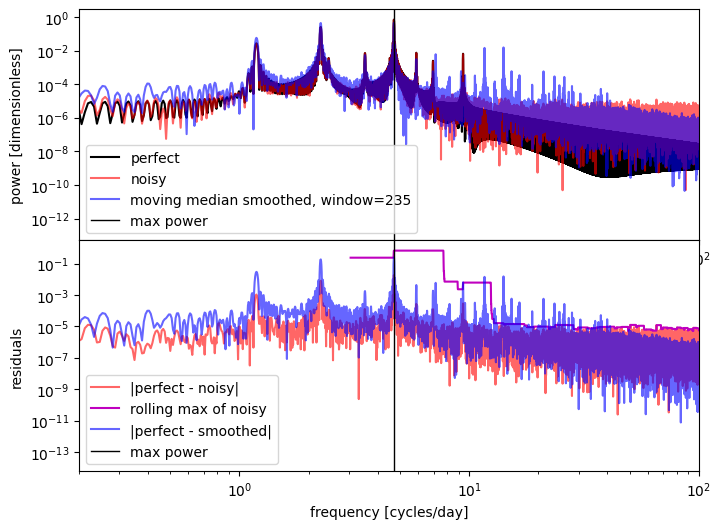

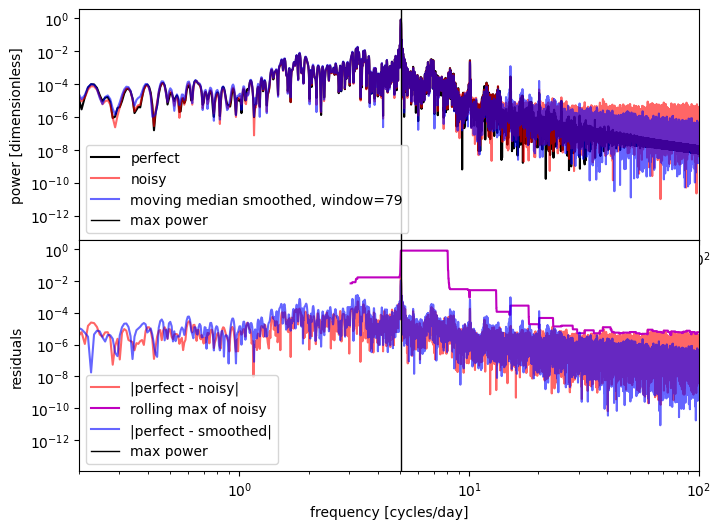

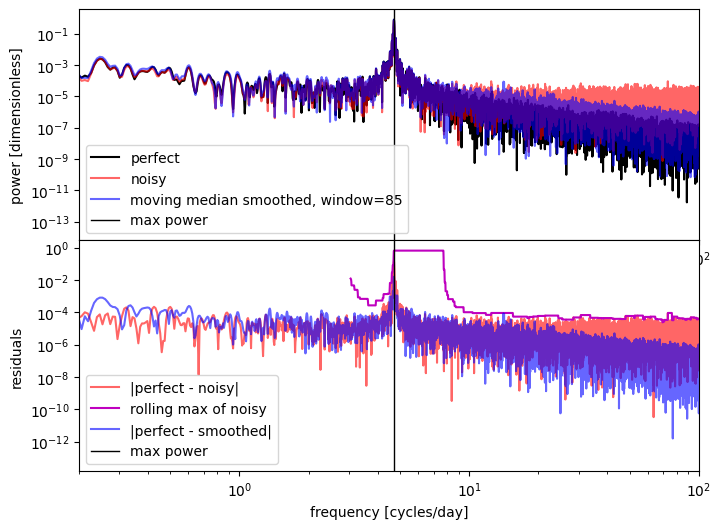

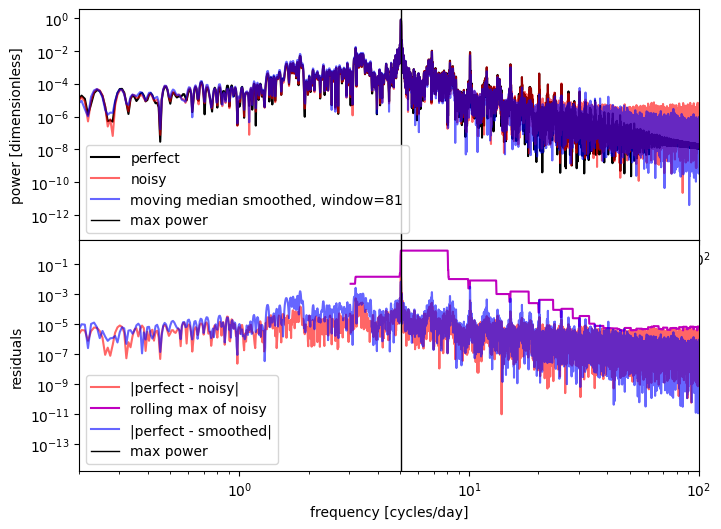

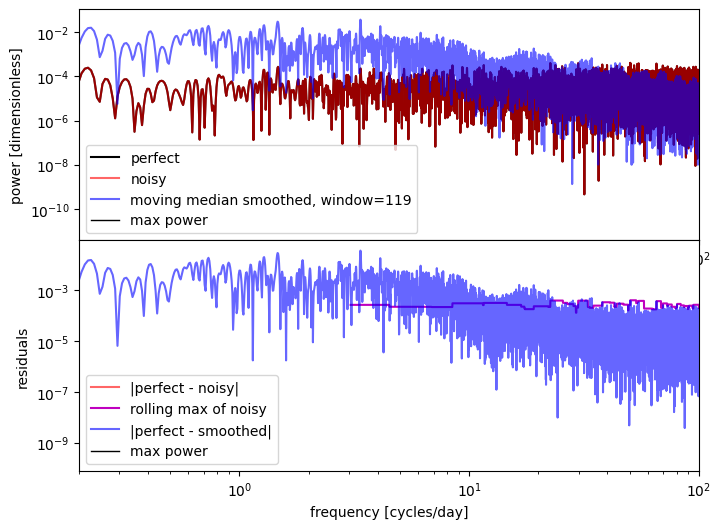

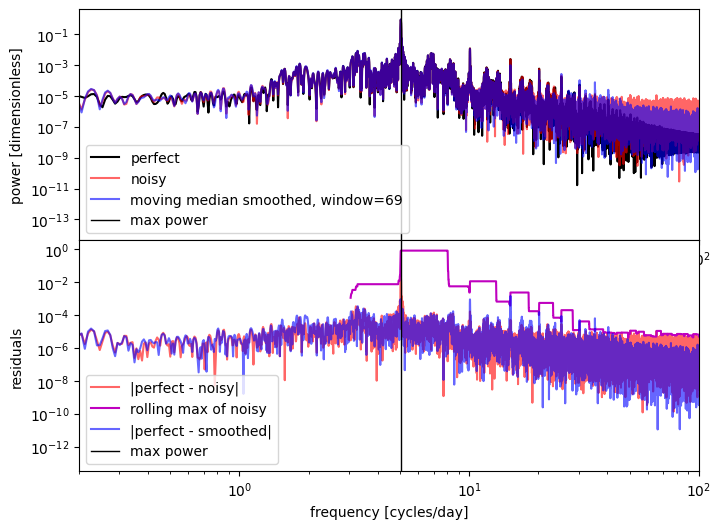

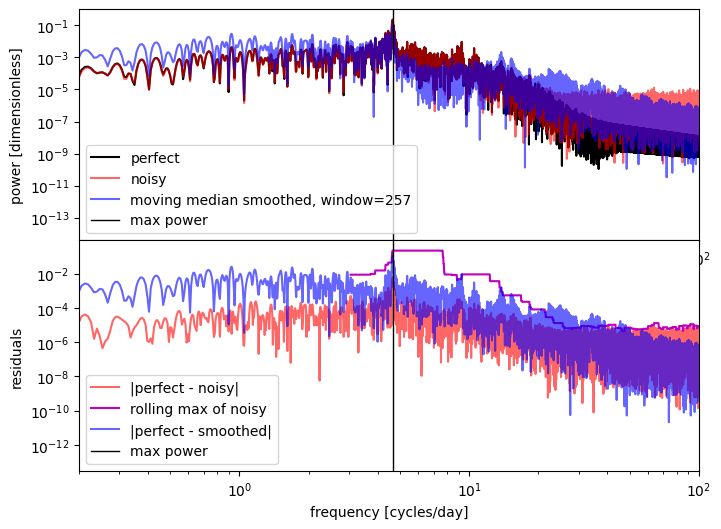

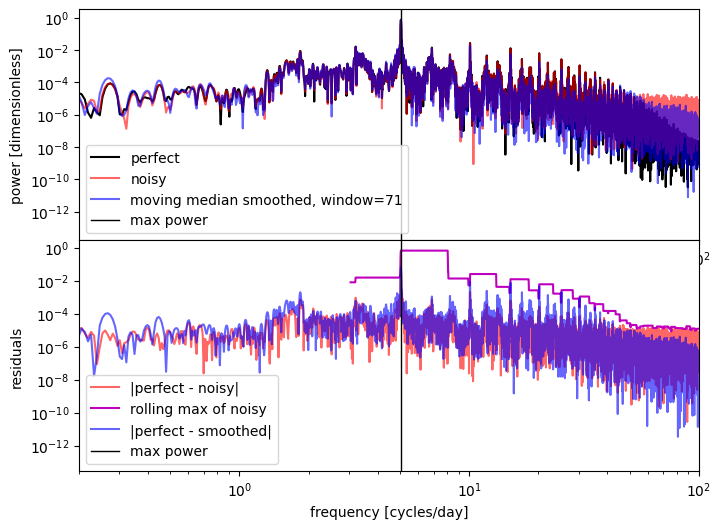

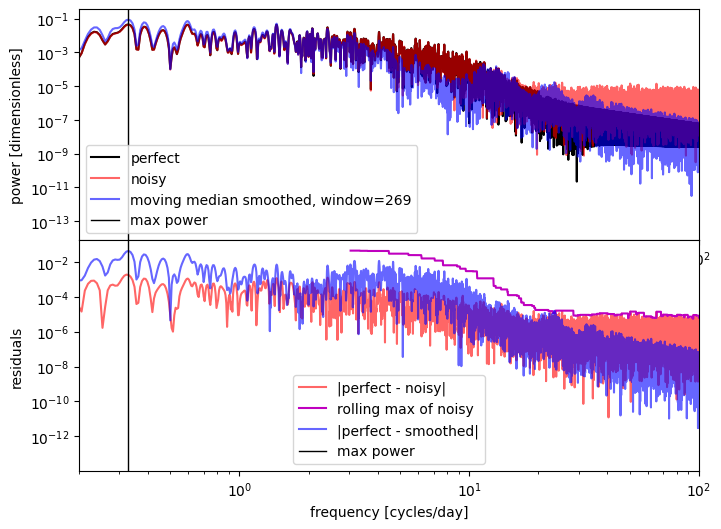

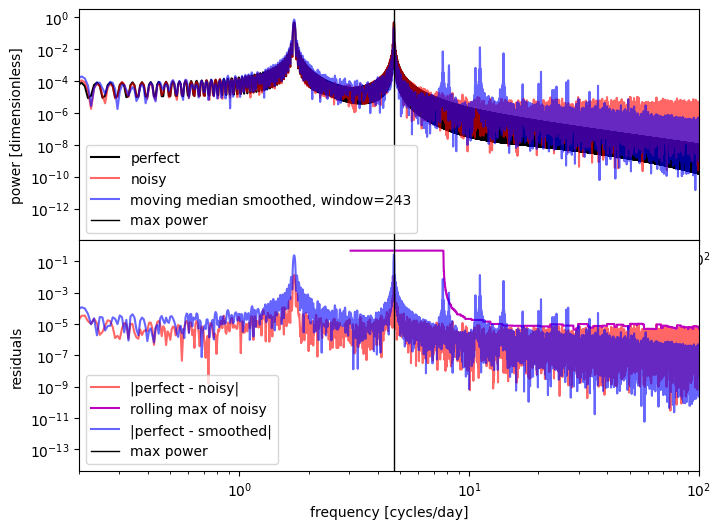

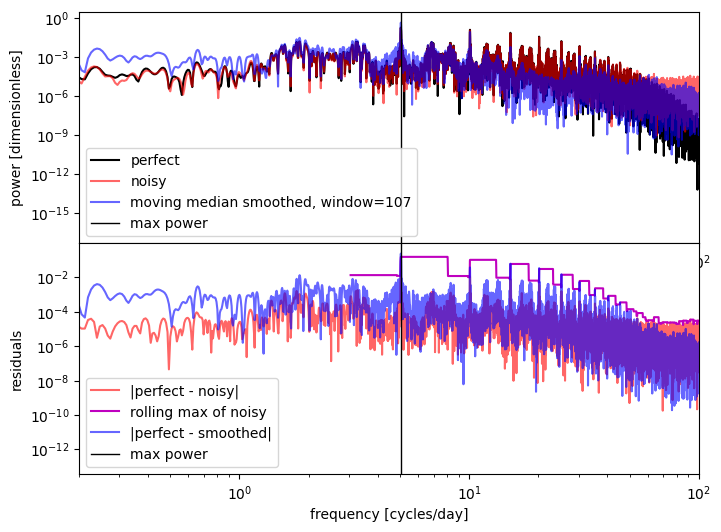

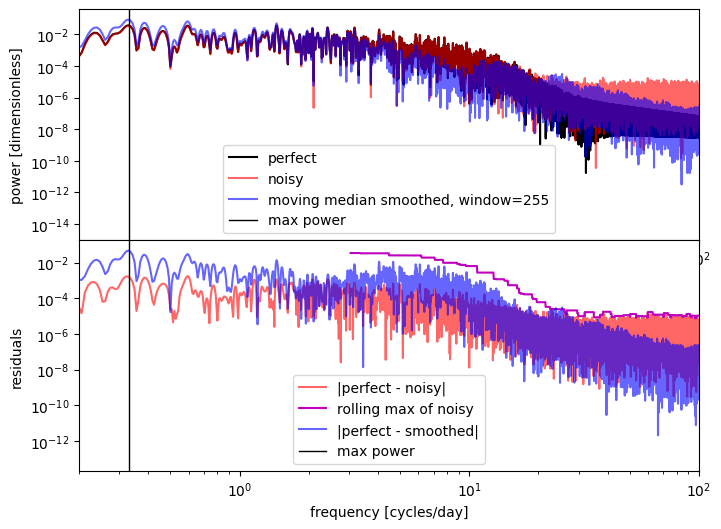

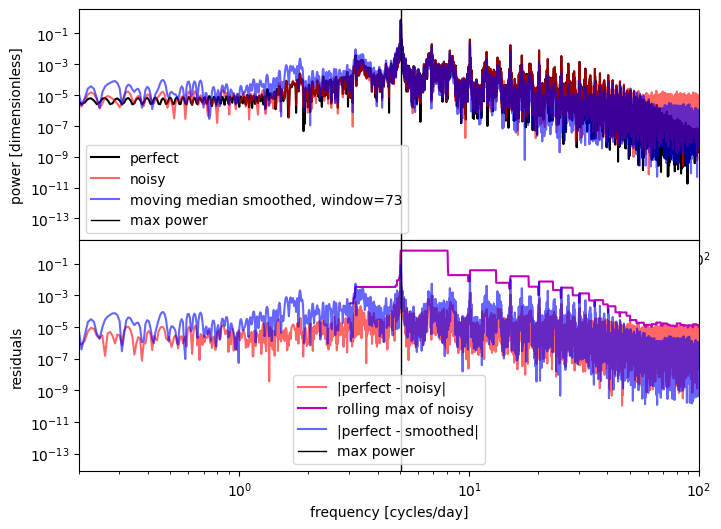

In [19]:
for tsp in list_of_tsps:
    print(tsp.filename)
    data = np.genfromtxt(tsp.filepath)

    if "0" in tsp.filename:
        ts = data[:,2]
        noisy_ts = data[:,2]
    else:
        ts = data[:,1]
        noisy_ts = data[:,2]

    print("perfect tauIdx is {0}, noisy tauIdx is {1}".format(tsp.bestTauIdx, tsp.noisy_bestTauIdx))
    print("sat_m is {0}, noisy_sat_m is {1}".format(tsp.sat_m, tsp.noisy_sat_m))

    if tsp.sat_m is None:
        tsp.sat_m = 10
    if tsp.noisy_sat_m is None:
        tsp.noisy_sat_m = 10

    #print("original time series length is {0}".format(len(ts)))
    #ts = ts[:5000]
    #noisy_ts = noisy_ts[:5000]
    #shortTime = data[:5000,0]
    shortTime = data[:,0]
    
    #print("short time series length is {0}".format(len(shortTime)))
    
    #LS periodograms
    min_freq=(1./np.ptp(shortTime)) #1/baseline
    max_freq=(1./(2.*(shortTime[1] - shortTime[0]))) #1/(2*cadence)

    frequency, power = LombScargle(shortTime,ts).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
    noisy_frequency, noisy_power = LombScargle(shortTime,noisy_ts).autopower(minimum_frequency=min_freq,maximum_frequency=max_freq)

    #rolling max of noisy power spectrum
    rm_noisy_power = np.array(pd.Series(noisy_power).rolling(window=int(len(shortTime)/100)).max())
    #find first place beyond the frequency of max power where the noisy power rolling maximum starts to increase
    #(remember, with real data, we won't have access to "true")
    maxNoisyPowerIdx = np.argmax(noisy_power)
    rm_noisy_power_diff = rm_noisy_power[1:] - rm_noisy_power[0:-1]

    incLocs = np.arange(len(rm_noisy_power_diff))[rm_noisy_power_diff > 0.]
    firstInc = incLocs[incLocs > maxNoisyPowerIdx+10][0]*2
    """
    #lowpass filter with that as the cutoff frequency (currently choice of order is not motivated)
    sos = butter(N=10, Wn = frequency[firstInc], btype='lowpass',output='sos',fs=(1./(shortTime[1] - shortTime[0])))
    smoothed_ts = sosfilt(sos,noisy_ts)
    """
    #print(tsp.QP)
    #print(tsp.noisy_QP)
    #print(tsp.bestTauIdx/tsp.QP)
    #print(tsp.noisy_bestTauIdx/tsp.noisy_QP)
    ks = int(tsp.bestTauIdx)#int(0.1*(tsp.noisy_bestTauIdx/tsp.noisy_QP)*tsp.noisy_QP)
    
    if ks%2==0:
        ks=ks+1
    smoothed_ts = medfilt(noisy_ts, kernel_size=ks)
    '''
    smoothed_frequency, smoothed_power = LombScargle(shortTime,smoothed_ts).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
    
    
    #plot the time series LS periodograms
    fig, axes = plt.subplots(2,1,sharex=False,figsize=(8,6))
    axes[0].plot(frequency,power,'k-',label="perfect")
    axes[0].plot(noisy_frequency,noisy_power,'r-',alpha=0.6,label="noisy")
    axes[0].plot(smoothed_frequency,smoothed_power,'b-',alpha=0.6,label="moving median smoothed, window={0}".format(ks))
    
    axes[1].plot(frequency,np.abs(power-noisy_power),'r-',alpha=0.6,label="|perfect - noisy|")
    axes[1].plot(frequency,rm_noisy_power,'m-',alpha=1,label="rolling max of noisy")
    axes[1].plot(frequency,np.abs(power-smoothed_power),'b-',alpha=0.6,label="|perfect - smoothed|")
    
    for ax in axes:
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlim(2.e-1,1.e2)
        ax.axvline(frequency[maxNoisyPowerIdx],color = 'k',lw=1,label="max power")
        #ax.axvline(frequency[firstInc],color='g',lw=1,label="first rolling max increase past f_maxpower*2")
        ax.legend(loc="best",fontsize=10)
        
    axes[0].set_ylabel('power [dimensionless]')
    axes[1].set_ylabel('residuals')
    axes[1].set_xlabel('frequency [cycles/day]')
    plt.subplots_adjust(hspace=0)
    #plt.show()
    plt.savefig("./timeseriesPlots/{0}_powerSpectra.png".format(tsp.filename.split(".txt")[0]),bbox_inches="tight")


    #plot the perfect, noisy, smoothed time series
    fig, axes = plt.subplots(2,1,figsize=(18,12))
    #axes[0].plot(data[:,0],ts,marker='None',ls='-',color='k',mec='None',lw=2,alpha=1)
    #axes[0].errorbar(data[:,0],noisy_ts,yerr=data[:,3],marker='.',ms=5,ls='-',color='r',mec='None',capsize=0.,elinewidth=0.5,lw=0.5,alpha=0.1)
    axes[0].plot(data[:,0],smoothed_ts,marker='None',ls='-',color='b',lw=1,alpha=1,label="moving median smoothed, window={0}".format(ks))

    #axes[1].plot(data[:,0],ts-noisy_ts,marker='None',ls='-',color='r',lw=1,alpha=0.5,label="perfect-noisy")
    axes[1].plot(data[:,0],noisy_ts-smoothed_ts,marker='None',ls='-',color='r',lw=1,alpha=0.5,label="noisy-smoothed")
    axes[1].plot(data[:,0],ts-smoothed_ts,marker='None',ls='-',color='b',lw=1,alpha=0.5,label="perfect-smoothed")
    
    for ax in axes:
        ax.set_ylabel(r"$x(t)$",fontsize=14)
        ax.set_xlim(data[:,0][0]-0.5, data[:,0][-1]+0.5)
        ax.legend(loc="lower right")
    axes[0].set_ylim(np.min(ts) - 0.1*np.ptp(ts), np.max(ts)+0.1*np.ptp(ts))
    #axes[1].set_ylim(-0.5*np.ptp(ts-smoothed_ts), 0.5*np.ptp(ts-smoothed_ts))
    axes[0].set_ylabel("perfect")
    axes[1].set_ylabel("residuals")
    axes[1].set_xlabel(r"$t$ [days]",fontsize=14)
    #plt.show()
    plt.savefig("./timeseriesPlots/{0}_timeseriesplot_filtered.png".format(tsp.filename.split(".txt")[0]),bbox_inches="tight")
    '''  


    #shorten
    #smoothed_ts = smoothed_ts[:10000]
    
    # scale ts to be between 0 and 1
    smoothed_ts = (smoothed_ts - np.min(smoothed_ts))/np.ptp(smoothed_ts)

    '''
    
    # just to see how things scale, run all the way up to Mmax=10
    start = time.time()
    smoothed_d2dict = sp.d2_tisean(timeSeries=smoothed_ts,tau=tsp.bestTauIdx,m=10,thelier=tsp.bestTauIdx)
    smoothedd2call = time.time()

    print("first d2 call took {0} seconds".format(np.round(smoothedd2call-start,2)))


    
    '''
    min_r = 1.e-3
    max_r = 1
    logrArr = np.linspace(np.log10(min_r),np.log10(max_r),100)
    rArr = 10**logrArr
    '''
    for m in range(4,11):
        print(m)
        
        start_cq = time.time()
        smoothed_C0, smoothed_C1, smoothed_C2, smoothed_nArr = sp.Cq(rArr, smoothed_ts, tau=tsp.bestTauIdx, m=m, theilerWindow=tsp.bestTauIdx)
    
        end_cq = time.time()
    
        print("Cq call took {0} minutes".format(np.round((end_cq - start_cq)/60, 2)))
        
        #np.save("./c2arrs/{0}_smoothedperfect_tisean_c2_norm0to1.npy".format(tsp.filename.split(".txt")[0]), smoothed_d2dict["c2"])
        #np.save("./c2arrs/{0}_smoothedperfect_tisean_d2_norm0to1.npy".format(tsp.filename.split(".txt")[0]), smoothed_d2dict["d2"])
        #np.save("./c2arrs/{0}_smoothedperfect_tisean_h2_norm0to1.npy".format(tsp.filename.split(".txt")[0]), smoothed_d2dict["h2"])
    
        np.save("./c2arrs/{0}_smoothed_c0_norm0to1_m={1}.npy".format(tsp.filename.split(".txt")[0],m), smoothed_C0)
        np.save("./c2arrs/{0}_smoothed_c1_norm0to1_m={1}.npy".format(tsp.filename.split(".txt")[0],m), smoothed_C1)
        np.save("./c2arrs/{0}_smoothed_c2_norm0to1_m={1}.npy".format(tsp.filename.split(".txt")[0],m), smoothed_C2)
        np.save("./c2arrs/{0}_smoothed_nArr_norm0to1_m={1}.npy".format(tsp.filename.split(".txt")[0],m), smoothed_nArr)
    '''    
   
    nArr = np.load("./c2arrs/{0}_nArr_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
    noisy_nArr = np.load("./c2arrs/{0}_noisy_nArr_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
    
    tisean_c2 = np.load("./c2arrs/{0}_tisean_c2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
    tisean_d2 = np.load("./c2arrs/{0}_tisean_d2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))

    noisy_tisean_c2 = np.load("./c2arrs/{0}_noisy_tisean_c2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
    noisy_tisean_d2 = np.load("./c2arrs/{0}_noisy_tisean_d2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))

    C2 = np.load("./c2arrs/{0}_c2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
    noisy_C2 = np.load("./c2arrs/{0}_noisy_c2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))

    D2 = (np.log10(C2[1:]) - np.log10(C2[0:-1]))/(logrArr[1] - logrArr[0])
    noisy_D2 = (np.log10(noisy_C2[1:]) - np.log10(noisy_C2[0:-1]))/(logrArr[1] - logrArr[0])
    
    C2unc = c2unc(rArr, C2, nArr, theilerWindow=tsp.bestTauIdx)
    noisy_C2unc =  c2unc(rArr, noisy_C2, noisy_nArr, theilerWindow=tsp.noisy_bestTauIdx)
    print("C2unc is:")
    print(C2unc)
    print("noisy C2unc is:")
    print(noisy_C2unc)
    D2unc = d2unc(logrArr, C2, C2unc)
    noisy_D2unc = d2unc(logrArr, noisy_C2, noisy_C2unc)
    
    if "0" not in tsp.filename:
        smoothed_nArr = np.load("./c2arrs/{0}_smoothed_nArr_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
        smoothedperfect_nArr = np.load("./c2arrs/{0}_smoothedperfect_nArr_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
        
        smoothed_tisean_c2 = np.load("./c2arrs/{0}_smoothed_tisean_c2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
        smoothed_tisean_d2 = np.load("./c2arrs/{0}_smoothed_tisean_d2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
    
        smoothedperfect_tisean_c2 = np.load("./c2arrs/{0}_smoothedperfect_tisean_c2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
        smoothedperfect_tisean_d2 = np.load("./c2arrs/{0}_smoothedperfect_tisean_d2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))

        smoothed_C2 = np.load("./c2arrs/{0}_smoothed_c2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))
        smoothedperfect_C2 = np.load("./c2arrs/{0}_smoothedperfect_c2_norm0to1.npy".format(tsp.filename.split(".txt")[0]))

        smoothed_D2 = (np.log10(smoothed_C2[1:]) - np.log10(smoothed_C2[0:-1]))/(logrArr[1] - logrArr[0])
        smoothedperfect_D2 = (np.log10(smoothedperfect_C2[1:]) - np.log10(smoothedperfect_C2[0:-1]))/(logrArr[1] - logrArr[0])

        smoothed_C2unc = c2unc(rArr, smoothed_C2, smoothed_nArr, theilerWindow=tsp.noisy_bestTauIdx)
        smoothedperfect_C2unc =  c2unc(rArr, smoothedperfect_C2, smoothedperfect_nArr, theilerWindow=tsp.bestTauIdx)

        smoothed_D2unc = d2unc(logrArr, smoothed_C2, smoothed_C2unc)
        smoothedperfect_D2unc = d2unc(logrArr, smoothedperfect_C2, smoothedperfect_C2unc)
    
    
    logrArr_int = (logrArr[0:-1] + logrArr[1:])/2.
    rArr_int = 10**logrArr_int

    #plt.plot(tisean_d2[1:,0] - tisean_d2[0:-1,0],'k.')
    #plt.show()

    # in order to plot d2 corresponding to the saturated value of m more clearly
    diff = (tisean_d2[1:,0] - tisean_d2[0:-1,0])
    diff_mask = (diff > 0.5)
    noisy_diff = (noisy_tisean_d2[1:,0] - noisy_tisean_d2[0:-1,0])
    noisy_diff_mask = (noisy_diff > 0.5)
    
    if "0" not in tsp.filename:
        smoothed_diff = (smoothed_tisean_d2[1:,0] - smoothed_tisean_d2[0:-1,0])
        smoothed_diff_mask = (smoothed_diff > 0.5)
        smoothedperfect_diff = (smoothedperfect_tisean_d2[1:,0] - smoothedperfect_tisean_d2[0:-1,0])
        smoothedperfect_diff_mask = (smoothedperfect_diff > 0.5)

    d2_m_switch_ind = np.arange(len(tisean_d2[1:,0]))[diff_mask]
    d2_m_switch_ind = np.concatenate((np.atleast_1d(np.array((0))), d2_m_switch_ind, np.atleast_1d(np.array((len(tisean_d2[:,0]))))))
    noisy_d2_m_switch_ind = np.arange(len(noisy_tisean_d2[1:,0]))[noisy_diff_mask] 
    noisy_d2_m_switch_ind = np.concatenate((np.atleast_1d(np.array((0))), noisy_d2_m_switch_ind,np.atleast_1d(np.array((len(noisy_tisean_d2[:,0]))))))
    
    if "0" not in tsp.filename:
        smoothed_d2_m_switch_ind = np.arange(len(smoothed_tisean_d2[1:,0]))[smoothed_diff_mask] 
        smoothed_d2_m_switch_ind = np.concatenate((np.atleast_1d(np.array((0))), smoothed_d2_m_switch_ind,np.atleast_1d(np.array((len(smoothed_tisean_d2[:,0]))))))
        smoothedperfect_d2_m_switch_ind = np.arange(len(smoothedperfect_tisean_d2[1:,0]))[smoothedperfect_diff_mask] 
        smoothedperfect_d2_m_switch_ind = np.concatenate((np.atleast_1d(np.array((0))), smoothedperfect_d2_m_switch_ind,np.atleast_1d(np.array((len(smoothedperfect_tisean_d2[:,0]))))))
    

    # "true" C2 values from Sprott & Rowlands 2000
    lorenz_C2_lower = 2.049-0.096
    lorenz_C2_upper = 2.049+0.096
    lorenz_KY = 2.062
    rossler_C2_lower = 1.986-0.078
    rossler_C2_upper = 1.986+0.078
    rossler_KY = 2.013
    
    fig, axes = plt.subplots(4,2,figsize=(12,16))
    """
    for m in range(2,11):
        perfect_m = np.load("./c2arrs/{0}_c2_norm0to1_m={1}.npy".format(tsp.filename.split(".txt")[0],m))
        noisy_m = np.load("./c2arrs/{0}_noisy_c2_norm0to1_m={1}.npy".format(tsp.filename.split(".txt")[0],m))

        nArr_ = np.load("./c2arrs/{0}_nArr_norm0to1_m={1}.npy".format(tsp.filename.split(".txt")[0],m))
        noisy_nArr_ = np.load("./c2arrs/{0}_noisy_nArr_norm0to1_m={1}.npy".format(tsp.filename.split(".txt")[0],m))

        C2unc_ = c2unc(rArr, perfect_m, nArr_, theilerWindow=tsp.bestTauIdx)
        noisy_C2unc_ = c2unc(rArr, noisy_m, noisy_nArr_, theilerWindow=tsp.noisy_bestTauIdx)

        D2unc_ = d2unc(logrArr, perfect_m, C2unc_)
        noisy_D2unc_ = d2unc(logrArr, noisy_m, noisy_C2unc_)
        
        if m==2:
            axes[0,0].errorbar(rArr, perfect_m, yerr=C2unc_, color='k',marker='x',capsize=0,elinewidth=1,ms=1,ls='None',zorder=m-1,label="my Euclidean c2, all m")
        else:
            axes[0,0].errorbar(rArr, perfect_m, yerr=C2unc_, color='k',marker='x',capsize=0,elinewidth=1,ms=1,ls='None',zorder=m-1)
        
        axes[1,0].errorbar(rArr, noisy_m, yerr=noisy_C2unc_, color='k',marker='x',capsize=0,elinewidth=1,ms=1,ls='None',zorder=m-1)

        D2_perfect_m = (np.log10(perfect_m[1:]) - np.log10(perfect_m[0:-1]))/(logrArr[1] - logrArr[0])
        D2_noisy_m = (np.log10(noisy_m[1:]) - np.log10(noisy_m[0:-1]))/(logrArr[1] - logrArr[0])
        axes[0,1].errorbar(rArr_int, D2_perfect_m, yerr=D2unc_, color='k',marker='x',capsize=0,elinewidth=1,ms=1,ls='None',zorder=m-1)
        axes[1,1].errorbar(rArr_int, D2_noisy_m,   yerr=noisy_D2unc_, color='k',marker='x',capsize=0,elinewidth=1,ms=1,ls='None',zorder=m-1)

        if "0" not in tsp.filename:
            smoothed_m = np.load("./c2arrs/{0}_smoothed_c2_norm0to1_m={1}.npy".format(tsp.filename.split(".txt")[0],m))
            smoothed_nArr_ = np.load("./c2arrs/{0}_smoothed_nArr_norm0to1_m={1}.npy".format(tsp.filename.split(".txt")[0],m))
            
            D2_smoothed_m = (np.log10(smoothed_m[1:]) - np.log10(smoothed_m[0:-1]))/(logrArr[1] - logrArr[0])

            smoothed_C2unc_ = c2unc(rArr, smoothed_m, smoothed_nArr_, theilerWindow=tsp.noisy_bestTauIdx)
            smoothed_D2unc_ = d2unc(logrArr, smoothed_m, smoothed_C2unc_)
            
            axes[2,0].errorbar(rArr, smoothed_m, yerr=smoothed_C2unc_, color='k',marker='x',capsize=0,elinewidth=1,ms=1,ls='None',zorder=m-1)
            axes[2,1].errorbar(rArr_int, D2_smoothed_m,  yerr=smoothed_D2unc_, color='k',marker='x',capsize=0,elinewidth=1,ms=1,ls='None',zorder=m-1)

    """            
    #perfect
    axes[0,0].scatter(tisean_c2[:,0], tisean_c2[:,1],s=0.1,c='k',label="TISEAN Chebyshev c2, all m",zorder=11)
    axes[0,0].scatter(tisean_c2[(tsp.sat_m-1)*100:tsp.sat_m*100,0], tisean_c2[(tsp.sat_m-1)*100:tsp.sat_m*100,1],s=3,c='r',label="TISEAN Chebyshev c2, sat_m",zorder=12)
    #axes[0,0].plot(rArr, C2, 'b.',ms=3,ls='None',label="my Euclidean c2, sat_m",zorder=13)
    axes[0,0].errorbar(rArr, C2, yerr=C2unc, color='b',marker='.',capsize=0,elinewidth=1,ms=3,ls='None',label="my Euclidean c2, sat_m",zorder=13)
    
    axes[0,0].set_yscale('log')
    axes[0,0].set_ylabel("correlation sum")
    axes[0,0].legend(loc="lower right",fontsize=8)

    axes[0,1].scatter(tisean_d2[:,0], tisean_d2[:,1],s=0.1,c='k',zorder=11)
    axes[0,1].scatter(tisean_d2[d2_m_switch_ind[tsp.sat_m-1]:d2_m_switch_ind[tsp.sat_m],0],tisean_d2[d2_m_switch_ind[tsp.sat_m-1]:d2_m_switch_ind[tsp.sat_m],1],s=3,c='r',zorder=12)
    #axes[0,1].plot(rArr_int, D2, 'b.',ms=3,ls='None',zorder=13)
    axes[0,1].errorbar(rArr_int, D2, yerr=D2unc, color='b',marker='.',capsize=0,elinewidth=1,ms=3,ls='None',zorder=13)
    axes[0,1].set_ylabel("correlation dimension")

    #noisy
    axes[1,0].scatter(noisy_tisean_c2[:,0], noisy_tisean_c2[:,1],s=0.1,c='k',zorder=11)
    axes[1,0].scatter(noisy_tisean_c2[(tsp.noisy_sat_m-1)*100:tsp.noisy_sat_m*100,0], noisy_tisean_c2[(tsp.noisy_sat_m-1)*100:tsp.noisy_sat_m*100,1],s=3,c='r',zorder=12)
    #axes[1,0].plot(rArr, noisy_C2, 'b.',ms=3,ls='None',zorder=13)
    axes[1,0].errorbar(rArr, noisy_C2, yerr=noisy_C2unc, color='b',marker='.',capsize=0,elinewidth=1,ms=3,ls='None',zorder=13)
    axes[1,0].set_yscale('log')
    axes[1,0].set_ylabel("correlation sum")

    axes[1,1].scatter(noisy_tisean_d2[:,0], noisy_tisean_d2[:,1],s=0.1,c='k',zorder=11)
    axes[1,1].scatter(noisy_tisean_d2[noisy_d2_m_switch_ind[tsp.noisy_sat_m-1]:noisy_d2_m_switch_ind[tsp.noisy_sat_m],0],noisy_tisean_d2[noisy_d2_m_switch_ind[tsp.noisy_sat_m-1]:noisy_d2_m_switch_ind[tsp.noisy_sat_m],1],s=3,c='r',zorder=12)
    #axes[1,1].plot(rArr_int, noisy_D2, 'b.',ms=3,ls='None',zorder=13)
    axes[1,1].errorbar(rArr_int, noisy_D2, yerr=noisy_D2unc, color='b',marker='.',capsize=0,elinewidth=1,ms=3,ls='None',zorder=13)
    axes[1,1].set_ylabel("correlation dimension")

    if "0" not in tsp.filename:
        #smoothed noisy
        axes[2,0].scatter(smoothed_tisean_c2[:,0], smoothed_tisean_c2[:,1],s=0.1,c='k',zorder=11)
        axes[2,0].scatter(smoothed_tisean_c2[(tsp.noisy_sat_m-1)*100:tsp.noisy_sat_m*100,0], smoothed_tisean_c2[(tsp.noisy_sat_m-1)*100:tsp.noisy_sat_m*100,1],s=3,c='r',zorder=12)
        #axes[2,0].plot(rArr, smoothed_C2, 'b.',ms=3,ls='None',zorder=13)
        axes[2,0].errorbar(rArr, smoothed_C2, yerr=smoothed_C2unc, color='b',marker='.',capsize=0,elinewidth=1,ms=3,ls='None',zorder=13)
        axes[2,0].set_yscale('log')
        axes[2,0].set_ylabel("correlation sum")
    
        axes[2,1].scatter(smoothed_tisean_d2[:,0], smoothed_tisean_d2[:,1],s=0.1,c='k',zorder=11)
        axes[2,1].scatter(smoothed_tisean_d2[smoothed_d2_m_switch_ind[tsp.noisy_sat_m-1]:smoothed_d2_m_switch_ind[tsp.noisy_sat_m],0], smoothed_tisean_d2[smoothed_d2_m_switch_ind[tsp.noisy_sat_m-1]:smoothed_d2_m_switch_ind[tsp.noisy_sat_m],1],s=3,c='r',zorder=12)
        #axes[2,1].plot(rArr_int, smoothed_D2, 'b.',ms=3,ls='None',zorder=13)
        axes[2,1].errorbar(rArr_int, smoothed_D2, yerr=smoothed_D2unc, color='b',marker='.',capsize=0,elinewidth=1,ms=3,ls='None',zorder=13)
        axes[2,1].set_ylabel("correlation dimension")
    
        #smoothed perfect
        axes[3,0].scatter(smoothedperfect_tisean_c2[:,0], smoothedperfect_tisean_c2[:,1],s=0.1,c='k',zorder=11)
        axes[3,0].scatter(smoothedperfect_tisean_c2[(tsp.sat_m-1)*100:tsp.sat_m*100,0], smoothedperfect_tisean_c2[(tsp.sat_m-1)*100:tsp.sat_m*100,1],s=3,c='r',zorder=12)
        axes[3,0].plot(rArr, smoothedperfect_C2, 'b.',ms=3,ls='None',zorder=13)
        axes[3,0].set_yscale('log')
        axes[3,0].set_ylabel("correlation sum")
    
        axes[3,1].scatter(smoothedperfect_tisean_d2[:,0], smoothedperfect_tisean_d2[:,1],s=0.1,c='k',zorder=11)
        axes[3,1].scatter(smoothedperfect_tisean_d2[smoothedperfect_d2_m_switch_ind[tsp.sat_m-1]:smoothedperfect_d2_m_switch_ind[tsp.sat_m],0], smoothedperfect_tisean_d2[smoothedperfect_d2_m_switch_ind[tsp.sat_m-1]:smoothedperfect_d2_m_switch_ind[tsp.sat_m],1],s=3,c='r',zorder=12)
        axes[3,1].plot(rArr_int, smoothedperfect_D2, 'b.',ms=3,ls='None',zorder=13)
        axes[3,1].set_ylabel("correlation dimension")

    
    if "4" in tsp.filename or "5" in tsp.filename:
        for ax in axes[:,1]:
            ax.axhline(rossler_KY, color='k',lw=0.5)
            ax.fill_between(np.linspace(7.e-4, 1.5, 3), y1=rossler_C2_lower*np.ones(3),y2=rossler_C2_upper*np.ones(3), color='k',alpha=0.1)
    elif "6" in tsp.filename:
        for ax in axes[:,1]:
            ax.axhline(lorenz_KY, color='k',lw=0.5)
            ax.fill_between(np.linspace(7.e-4, 1.5, 3), y1=lorenz_C2_lower*np.ones(3),y2=lorenz_C2_upper*np.ones(3), color='k',alpha=0.1)
            
    for ax in np.ravel(axes):
        ax.set_xscale('log')
        ax.set_xlim(7.e-4, 1.5)

    for ax in axes[3]:
        ax.set_xlabel('length scale')

    for ax in axes[:,0]:
        ax.set_ylim(np.min(tisean_c2[:,1]),1.5)

    for ax in axes[:,1]:
        ax.set_ylim(-0.5, 8)

    #for ax in axes[:,2]:
    #    ax.set_ylim(-0.5,6.5)

    axes[0,0].set_title("sat_m = {0}".format(tsp.sat_m))
    axes[1,0].set_title("noisy sat_m = {0}".format(tsp.noisy_sat_m))
    axes[2,0].set_title("noisy, moving median smoothed",color='g')
    axes[3,0].set_title("perfect, moving median smoothed")

    plt.subplots_adjust(hspace=0.2)
    #plt.show()
    plt.savefig("./c2Plots/{0}_norm0to1_Cq_comp_smoothed_minimalistplot.png".format(tsp.filename.split(".txt")[0]),bbox_inches="tight")
    plt.close()    
    

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np


b, a = signal.butter(10, 100, 'low', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()


t = np.linspace(0, 1, 1000, False)  # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])


sos = signal.butter(10, 15, 'hp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()